In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

In [2]:
d1 = pd.read_csv('CHF.csv')
d2 = pd.read_csv('EUR.csv')
d3 = pd.read_csv('GBP.csv')
d4 = pd.read_csv('JPY.csv')

names = ['CHF', 'EUR', 'GBP', 'JPY']

def pre_process_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    # Set frequency to monthly
    df = df.asfreq('M')
    df = df.sort_index()

    col_in_df = df.columns[0]
    df.rename(columns={col_in_df: 'Price'}, inplace=True)
    df["log_ret"] = np.log(df['Price'] / df['Price'].shift(1))

    df = df.dropna()
    return df

data_frames = [pre_process_data(d) for d in [d1, d2, d3, d4]]

df = pd.concat([data_frames[i]['log_ret'].rename(names[i]) for i in range(len(names))], axis=1)

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 609 entries, 1975-02-28 to 2025-10-31
Freq: ME
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CHF     609 non-null    float64
 1   EUR     609 non-null    float64
 2   GBP     609 non-null    float64
 3   JPY     609 non-null    float64
dtypes: float64(4)
memory usage: 23.8 KB
None


,CHF,EUR,GBP,JPY
Date,,,,
1975-02-28,-0.019886,-0.015064,-0.013557,-0.026517
1975-03-31,0.000889,-0.010353,-0.010350,-0.015301
1975-04-30,0.032064,0.015355,0.020358,0.016396
1975-05-31,-0.019505,-0.013986,0.021113,-0.002675
1975-06-30,-0.005598,-0.004248,0.017944,0.007245


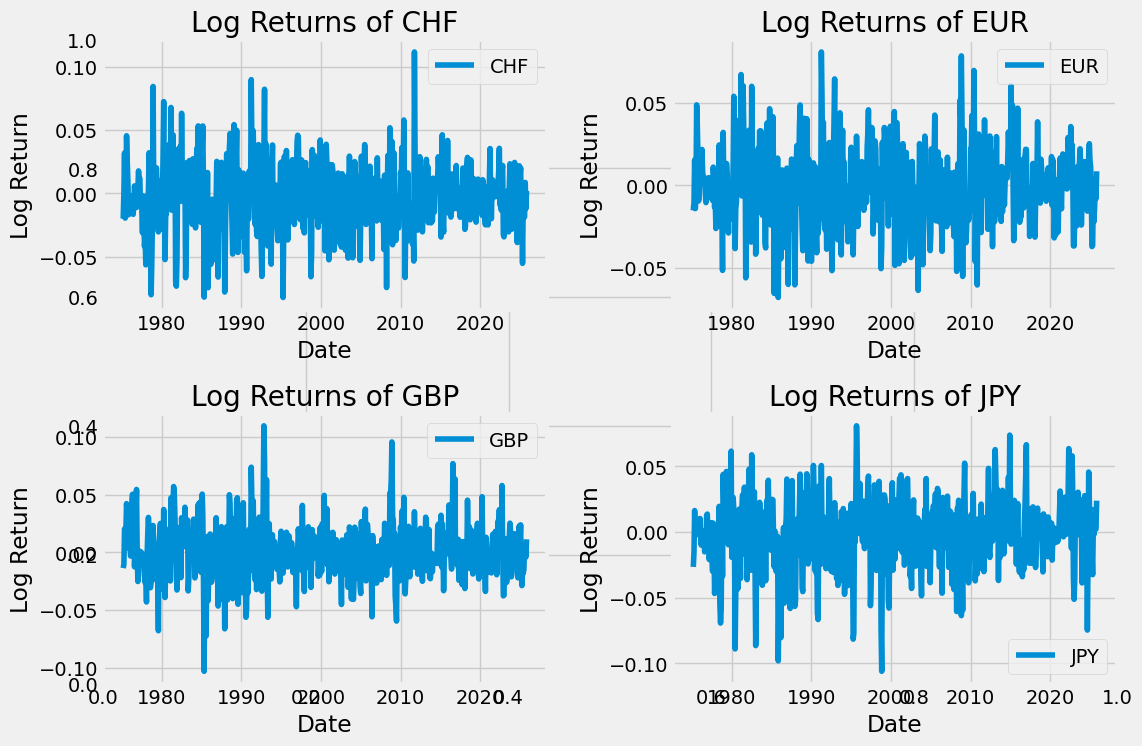

In [3]:
plt.subplots(figsize=(12, 8))

for i, name in enumerate(names):
    plt.subplot(2, 2, i + 1)
    plt.plot(df.index, df[name], label=name)
    plt.title(f'Log Returns of {name}')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()

plt.tight_layout()
plt.show()

In [4]:
# Instantiate class and fit model
from TVPVARConnectedness import TVPVARConnectedness

vars_order = names

Y = df[vars_order].values
labels = names

model = TVPVARConnectedness(
    y=Y, lags=1, horizon=10,
    kappa1=0.99, kappa2=0.96,
    prior_length=252, dates=df.index.to_numpy()
).fit()

(<Figure size 1600x1000 with 6 Axes>,
 array([<Axes: title={'center': 'net CHF → EUR'}>,
        <Axes: title={'center': 'net CHF → GBP'}>,
        <Axes: title={'center': 'net CHF → JPY'}>,
        <Axes: title={'center': 'net EUR → GBP'}>,
        <Axes: title={'center': 'net EUR → JPY'}>,
        <Axes: title={'center': 'net GBP → JPY'}>], dtype=object))

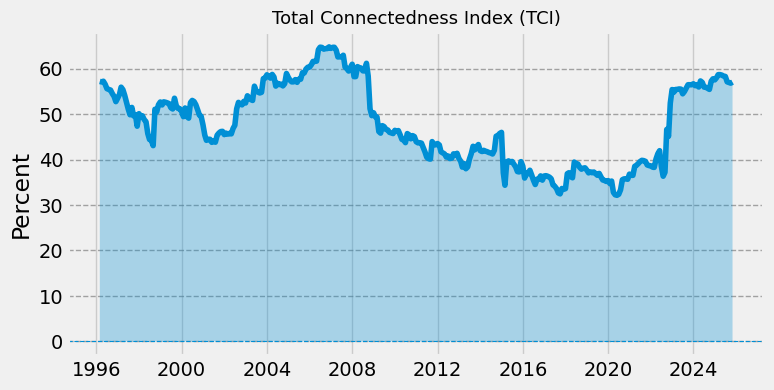

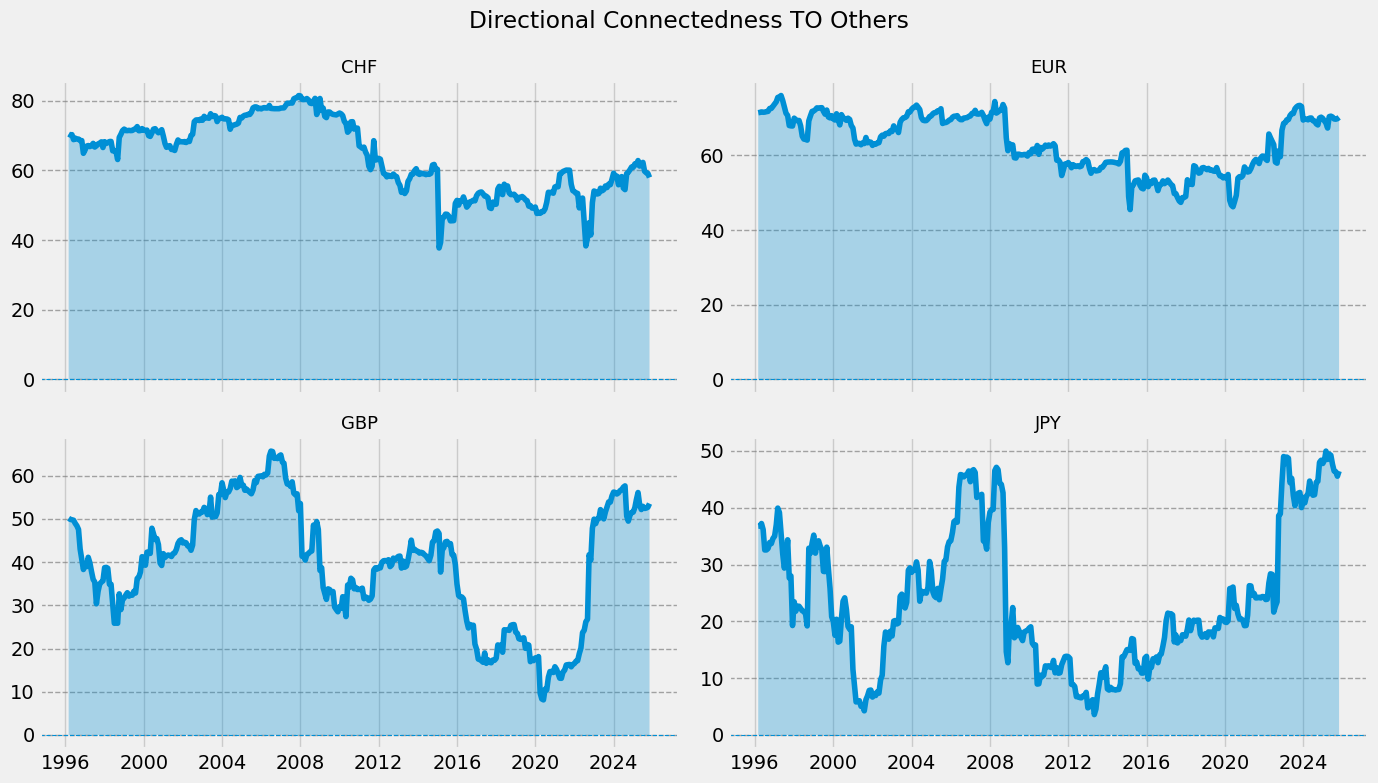

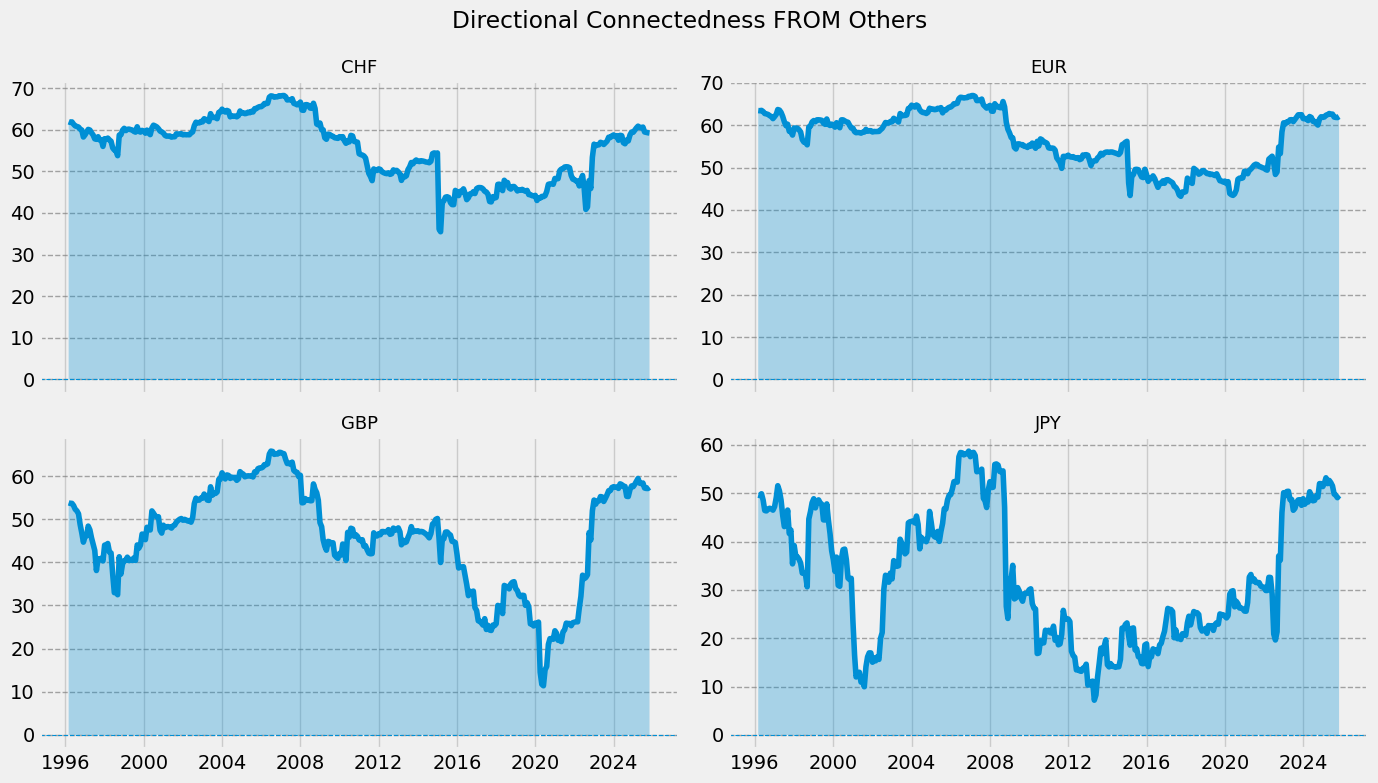

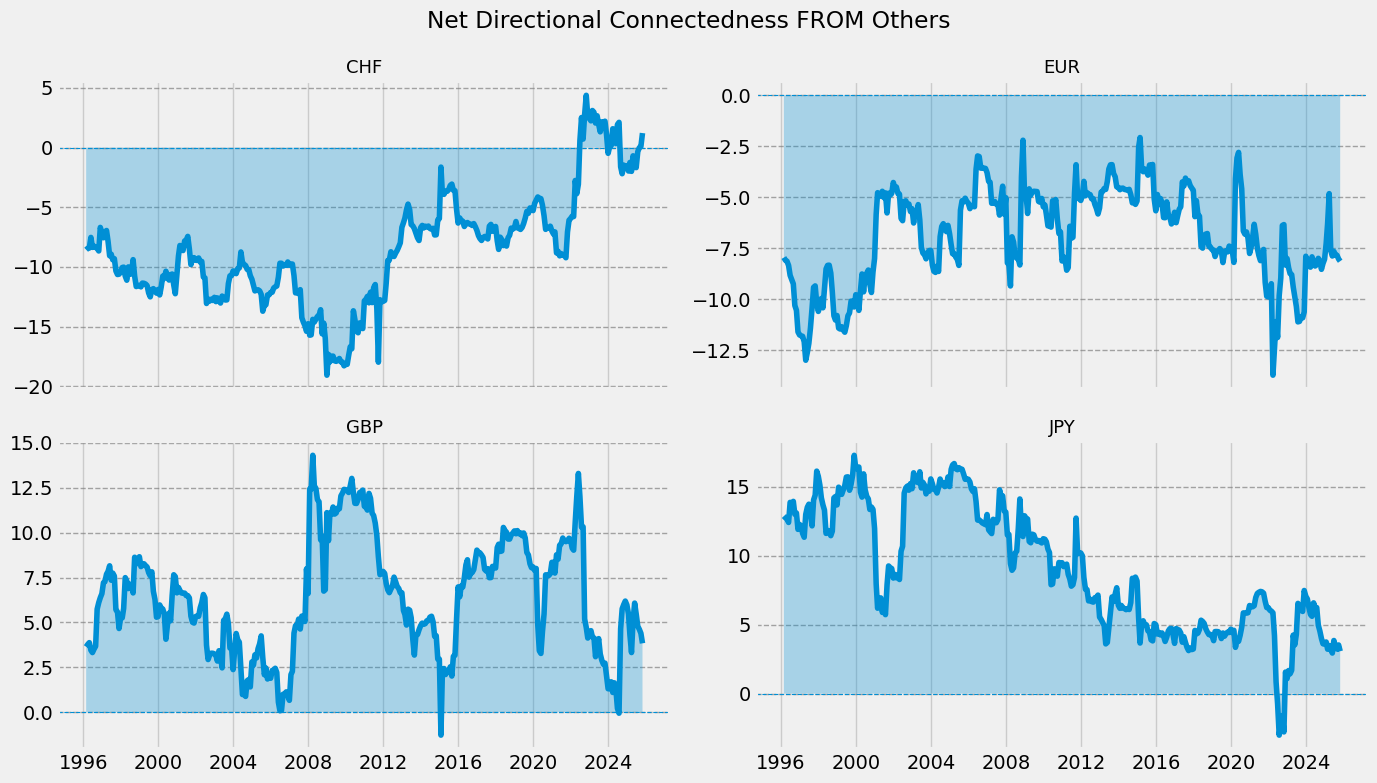

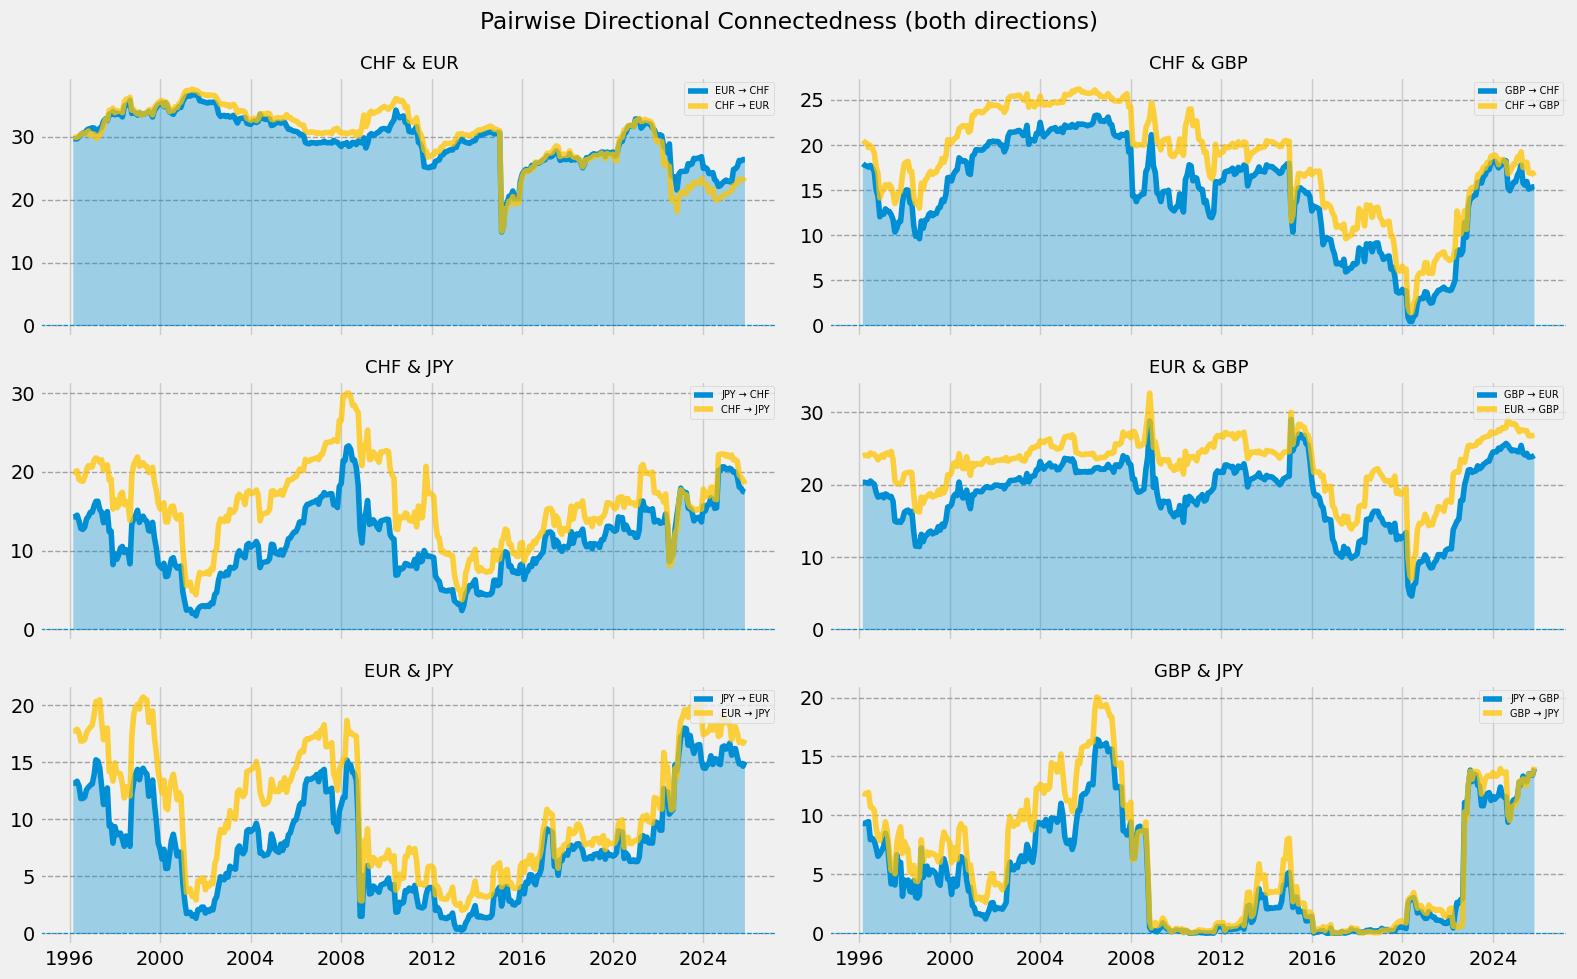

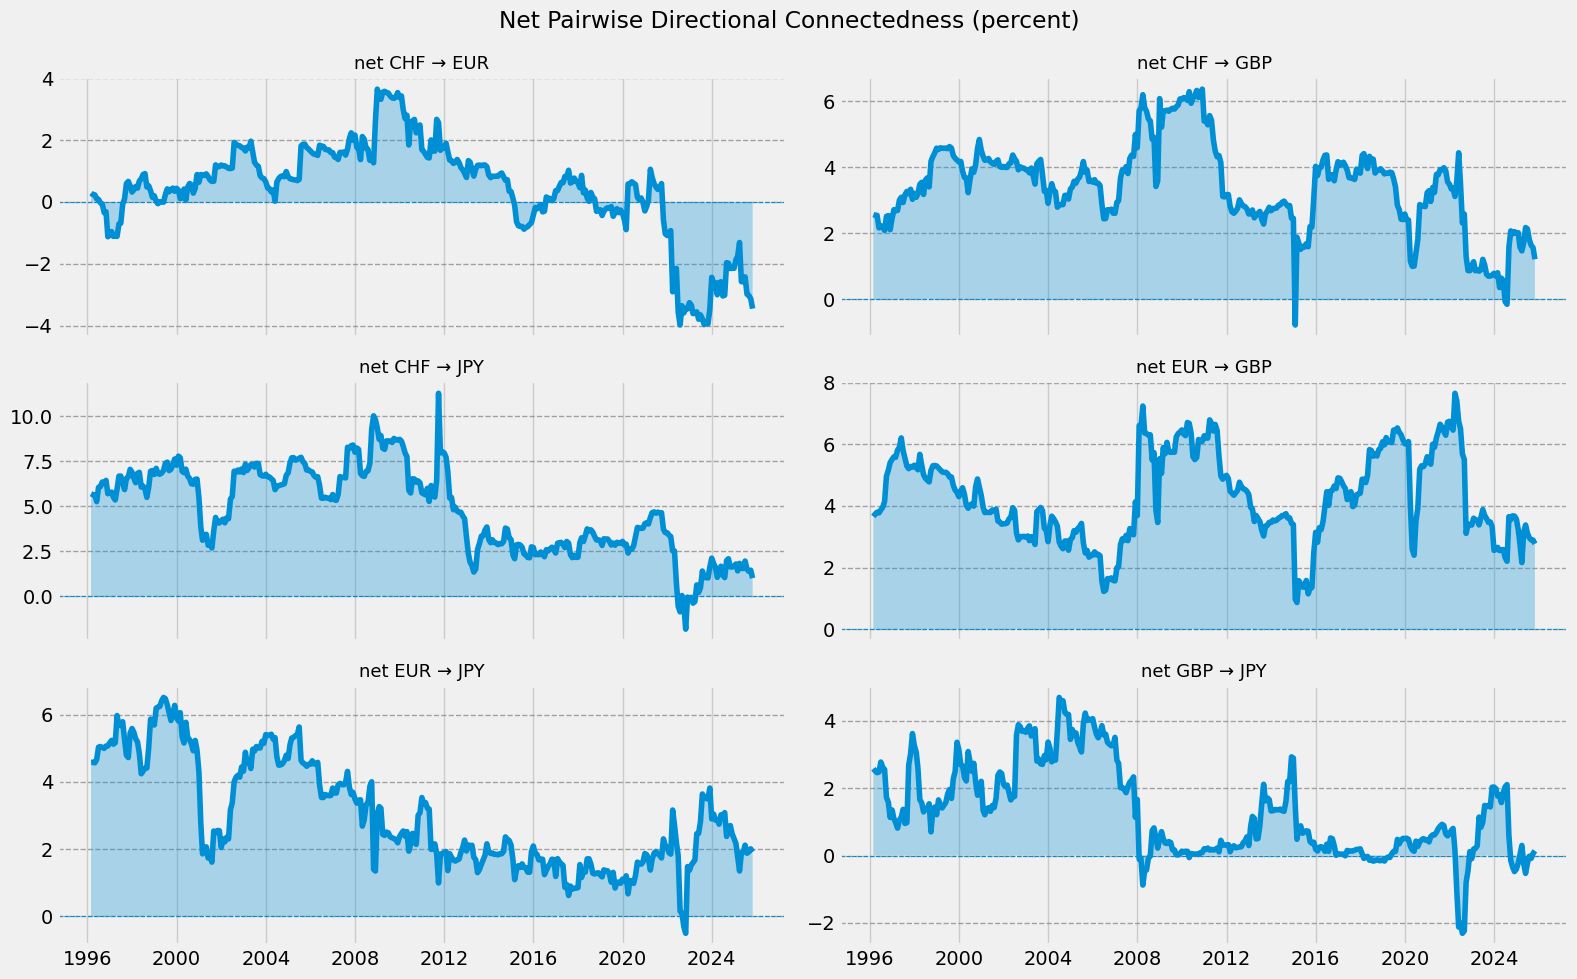

In [5]:
# TCI (single plot)
model.plot_tci()

# Directional subplots
model.plot_directional_subplots(which="to",       labels=labels)
model.plot_directional_subplots(which="from",     labels=labels)
model.plot_directional_subplots(which="net_from", labels=labels)

# Pairwise directional and net-pairwise subplots
model.plot_pairwise_directional_subplots(labels=labels, which='both')
model.plot_net_pairwise_subplots(labels=labels)

In [6]:
connectednes_table = model.get_static_table_df(labels=labels)
connectednes_table.to_excel('connectednes_table.xlsx')
connectednes_table

,CHF,EUR,GBP,JPY,FROM
CHF,44.498250,29.595395,14.682872,11.223482,55.501750
EUR,29.984301,43.434790,18.673049,7.907860,56.565210
GBP,18.091785,22.953154,54.140820,4.814240,45.859180
JPY,16.003116,10.894142,6.096026,67.006717,32.993283
TO,64.079202,63.442691,39.451947,23.945583,NaN
FROM,55.501750,56.565210,45.859180,32.993283,NaN
NET,8.577453,6.877481,-6.407233,-9.047701,47.729856


(<Figure size 1000x1000 with 4 Axes>,
 array([<Axes: title={'center': 'Net connectedness on 1996-02-29 (Index = 57.2%)'}>,
        <Axes: title={'center': 'Net connectedness on 2004-06-30 (Index = 56.8%)'}>,
        <Axes: title={'center': 'Net connectedness on 2012-10-31 (Index = 41.0%)'}>,
        <Axes: title={'center': 'Net connectedness on 2025-10-31 (Index = 57.0%)'}>],
       dtype=object))

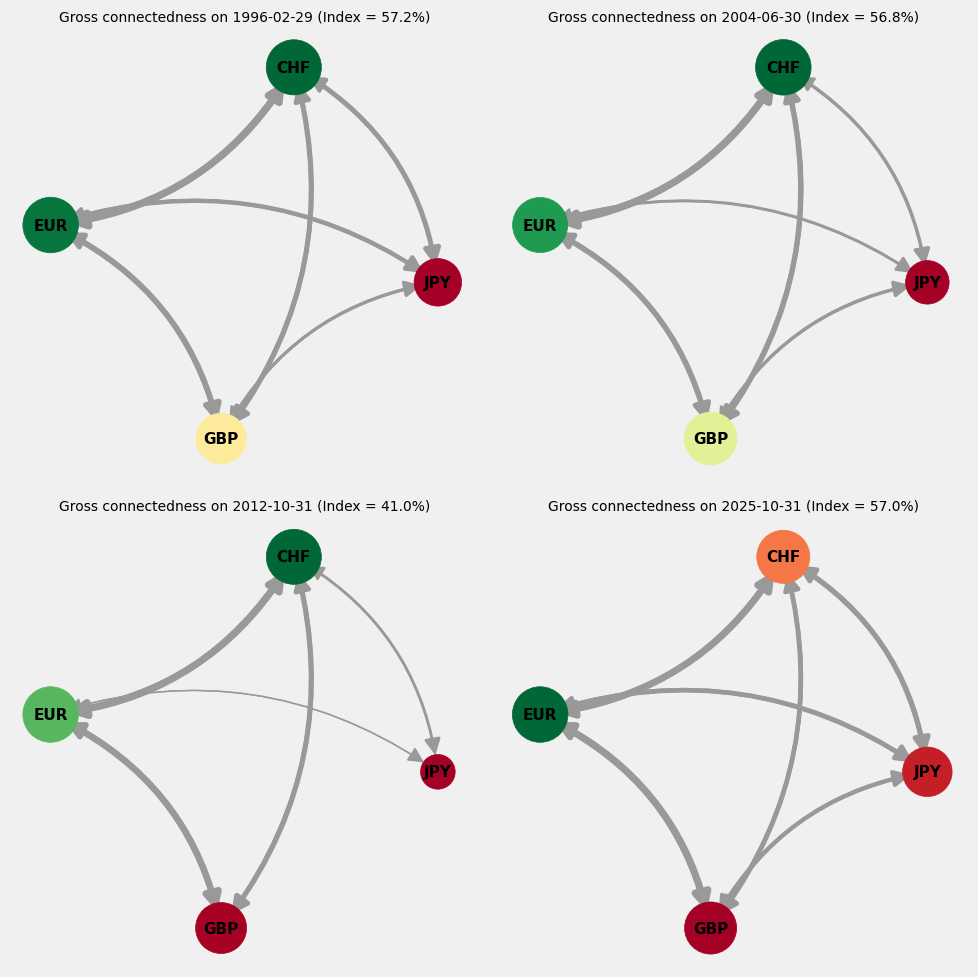

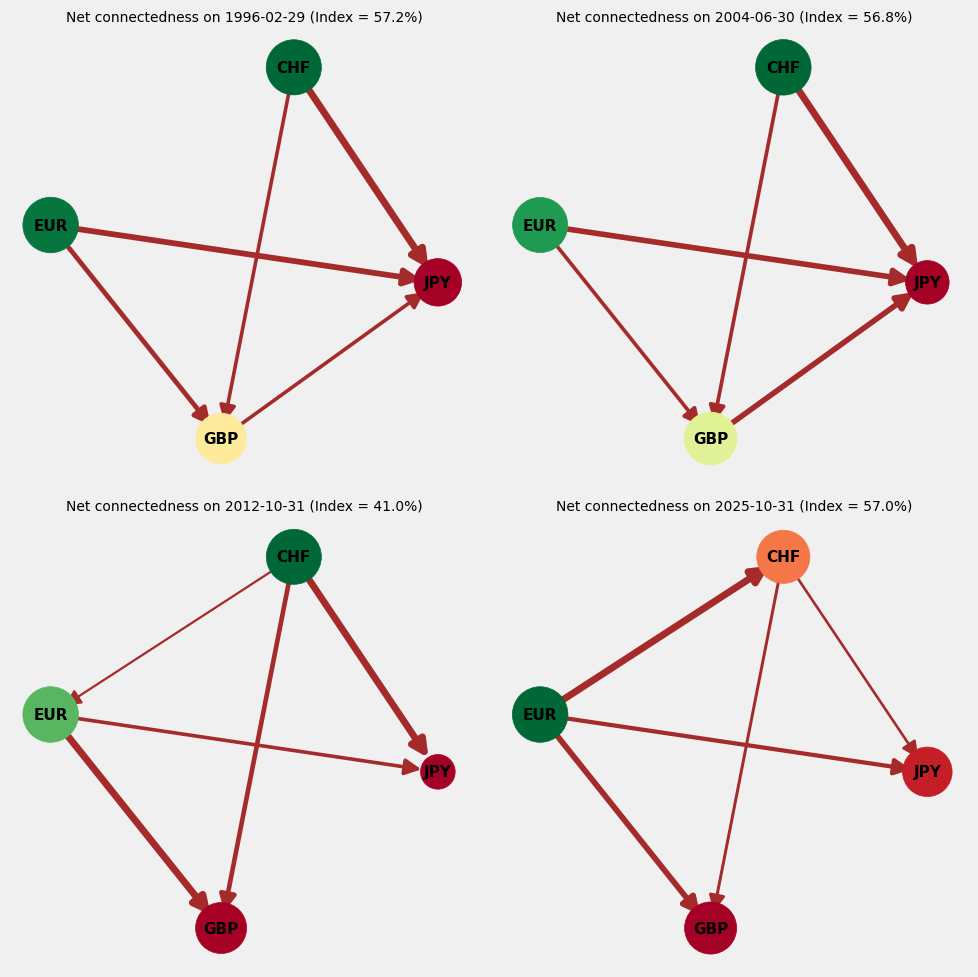

In [7]:
# Network plots with specified by index
model.plot_network_panel(times=[0, 100, 200, -1], labels=labels, use_net=False)
model.plot_network_panel(times=[0, 100, 200, -1], labels=labels, use_net=True)